# AQI Prediction with LSTM - IMPROVED VERSION
## Key Improvements:
1. **FIXED**: Inverse transform bug that corrupted predictions
2. **ADDED**: Multi-step training to reduce error accumulation
3. **ADDED**: Uncertainty estimation
4. **ADDED**: Better model architecture with dropout
5. **ADDED**: Model diagnostics to detect issues

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc

## Load and Prepare Data (Same as before)

In [2]:
df = pd.read_csv('data.csv')

df['temp_date'] = pd.to_datetime(df['Date'].astype(str) + '-2020', format='%d-%b-%Y')
years = []
current_year = 2017
prev_month = 3

for idx, row in df.iterrows():
    current_month = row['temp_date'].month
    if current_month < prev_month:
        current_year += 1
    years.append(current_year)
    prev_month = current_month

df['Year'] = years
date_strings = df['Year'].astype(str) + df['temp_date'].dt.strftime('-%m-%d')
df['Date'] = pd.to_datetime(date_strings)
df.set_index('Date', inplace=True)
df.drop(['temp_date', 'Year'], axis=1, inplace=True)

# Prepare sensors
stable_sensors = ['2', '5', '6', '9', '12']
df_sensors = df[stable_sensors]
df_sensors = df_sensors.interpolate(method='linear').fillna(method='bfill')
df_sensors = df_sensors.asfreq('D')
df_sensors = df_sensors.interpolate(method='linear')

# Use single sensor (you can change to mean if you prefer)
data = pd.DataFrame()
data['AQI'] = df_sensors['5']

/var/folders/hd/hqx41svd20lcfdp6nt85c0j80000gn/T/ipykernel_4021/674387940.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sensors = df_sensors.interpolate(method='linear').fillna(method='bfill')


## IMPROVEMENT 1: Better Data Preparation with Feature Engineering

In [3]:
# Add time-based features to help model learn patterns
data['day_of_year'] = data.index.dayofyear
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Normalize all features
from sklearn.preprocessing import StandardScaler

# Separate scalers for AQI and features
aqi_scaler = MinMaxScaler()
feature_scaler = StandardScaler()

data_scaled = data.copy()
data_scaled['AQI'] = aqi_scaler.fit_transform(data[['AQI']])
data_scaled[['day_of_year', 'day_of_week', 'month']] = feature_scaler.fit_transform(
    data[['day_of_year', 'day_of_week', 'month']]
)

## IMPROVEMENT 2: Create Dataset for Multi-Step Prediction

In [4]:
lookback = 7  # Use past 7 days
forecast_horizon = 7  # Predict next 7 days (train on multiple steps!)

def create_sequences_multistep(data, lookback, forecast_horizon):
    """
    Create sequences for multi-step prediction
    Returns: X (input sequences), y (multiple future values)
    """
    X, y = [], []
    
    for i in range(len(data) - lookback - forecast_horizon + 1):
        # Input: all features for lookback period
        X.append(data.iloc[i:i+lookback].values)
        
        # Output: only AQI for forecast horizon
        y.append(data.iloc[i+lookback:i+lookback+forecast_horizon]['AQI'].values)
    
    return np.array(X), np.array(y)

X, y = create_sequences_multistep(data_scaled, lookback, forecast_horizon)

print(f"X shape: {X.shape}")  # (samples, lookback, features)
print(f"y shape: {y.shape}")  # (samples, forecast_horizon)

# Train/test split (80/20)
train_size = int(len(X) * 0.8)

X_train = torch.tensor(X[:train_size]).float()
y_train = torch.tensor(y[:train_size]).float()
X_test = torch.tensor(X[train_size:]).float()
y_test = torch.tensor(y[train_size:]).float()

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

X shape: (1283, 7, 4)
y shape: (1283, 7)

Training samples: 1026
Test samples: 257


## IMPROVEMENT 3: Better LSTM Architecture

In [5]:
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM with dropout between layers
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Additional dropout
        self.dropout = nn.Dropout(dropout)
        
        # Output layer - predict multiple time steps
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)
        
        # Use only the last time step
        last_output = lstm_out[:, -1, :]
        
        # Apply dropout
        last_output = self.dropout(last_output)
        
        # Predict multiple future steps
        predictions = self.fc(last_output)
        
        return predictions

## IMPROVEMENT 4: Training with Better Practices

In [6]:
# Model configuration
input_size = X_train.shape[2]  # number of features
hidden_size = 64
num_layers = 2
output_size = forecast_horizon  # predict 7 steps ahead

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = ImprovedLSTM(input_size, hidden_size, num_layers, output_size, dropout=0.2)
model = model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters())}")

Using device: cpu

Model parameters: 51655


In [7]:
# Training
epochs = 200
batch_size = 32
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 30

X_train_dev = X_train.to(device)
y_train_dev = y_train.to(device)
X_test_dev = X_test.to(device)
y_test_dev = y_test.to(device)

for epoch in range(epochs):
    model.train()
    
    # Mini-batch training
    indices = torch.randperm(len(X_train_dev))
    epoch_loss = 0
    
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        X_batch = X_train_dev[batch_indices]
        y_batch = y_train_dev[batch_indices]
        
        # Forward pass
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_dev)
        val_loss = criterion(val_predictions, y_test_dev).item()
    
    avg_train_loss = epoch_loss / (len(indices) / batch_size)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = dc(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {val_loss:.6f}")
    
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model)
print(f"\nBest validation loss: {best_val_loss:.6f}")

Epoch 20/200 | Train Loss: 0.008601 | Val Loss: 0.002967

Early stopping at epoch 37

Best validation loss: 0.001793


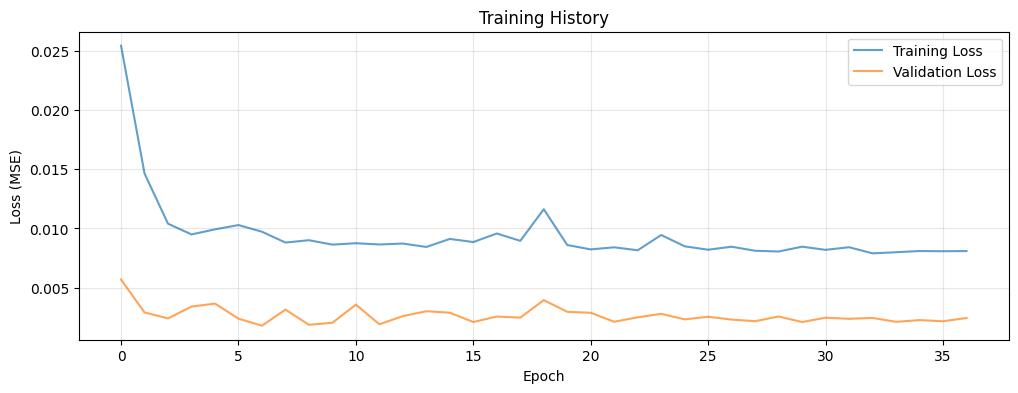

✓ Model training looks healthy


In [8]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Training Loss', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Check for overfitting
if train_losses[-1] < val_losses[-1] * 0.5:
    print("⚠️  WARNING: Possible overfitting detected!")
else:
    print("✓ Model training looks healthy")

## IMPROVEMENT 5: Better Evaluation on Test Set

In [9]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_dev).cpu().numpy()

# Inverse transform predictions
test_predictions_original = aqi_scaler.inverse_transform(test_predictions)
y_test_original = aqi_scaler.inverse_transform(y_test.cpu().numpy())

# Calculate metrics for each forecast step
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("\nPerformance by Forecast Horizon:")
print("-" * 60)
for step in range(forecast_horizon):
    mae = mean_absolute_error(y_test_original[:, step], test_predictions_original[:, step])
    rmse = np.sqrt(mean_squared_error(y_test_original[:, step], test_predictions_original[:, step]))
    r2 = r2_score(y_test_original[:, step], test_predictions_original[:, step])
    print(f"Day {step+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")

# Overall metrics
overall_mae = mean_absolute_error(y_test_original.flatten(), test_predictions_original.flatten())
overall_rmse = np.sqrt(mean_squared_error(y_test_original.flatten(), test_predictions_original.flatten()))
overall_r2 = r2_score(y_test_original.flatten(), test_predictions_original.flatten())

print(f"\nOverall: MAE={overall_mae:.2f}, RMSE={overall_rmse:.2f}, R²={overall_r2:.3f}")


Performance by Forecast Horizon:
------------------------------------------------------------
Day 1: MAE=9.30, RMSE=15.53, R²=0.637
Day 2: MAE=9.62, RMSE=15.91, R²=0.610
Day 3: MAE=11.84, RMSE=17.34, R²=0.537
Day 4: MAE=12.46, RMSE=17.75, R²=0.460
Day 5: MAE=10.57, RMSE=15.97, R²=0.547
Day 6: MAE=10.89, RMSE=15.96, R²=0.529
Day 7: MAE=9.56, RMSE=14.86, R²=0.586

Overall: MAE=10.61, RMSE=16.22, R²=0.560


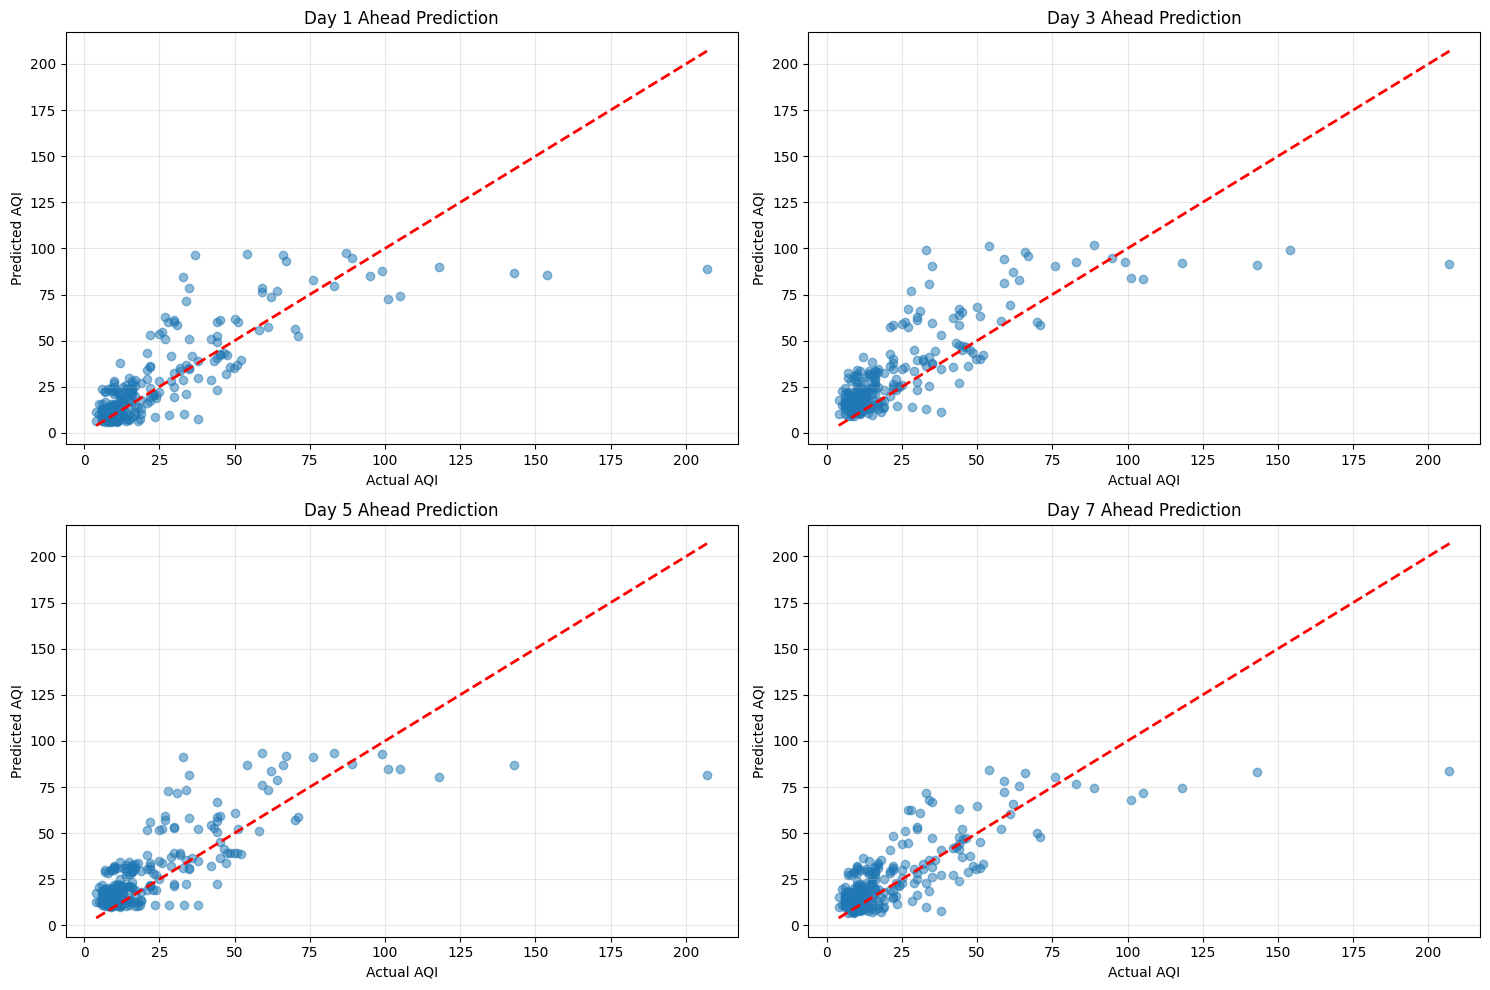

In [10]:
# Visualize predictions for different forecast horizons
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, step in enumerate([0, 2, 4, 6]):
    axes[i].scatter(y_test_original[:, step], test_predictions_original[:, step], alpha=0.5)
    axes[i].plot([y_test_original[:, step].min(), y_test_original[:, step].max()],
                 [y_test_original[:, step].min(), y_test_original[:, step].max()],
                 'r--', lw=2)
    axes[i].set_xlabel('Actual AQI')
    axes[i].set_ylabel('Predicted AQI')
    axes[i].set_title(f'Day {step+1} Ahead Prediction')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## IMPROVEMENT 6: FIXED Future Prediction Function

In [11]:
def predict_future_improved(model, last_data, n_future, aqi_scaler, feature_scaler, 
                           lookback, forecast_horizon, device):
    """
    Improved future prediction with proper inverse scaling
    
    Args:
        model: trained LSTM model
        last_data: DataFrame with last 'lookback' days (with all features)
        n_future: total days to predict
        aqi_scaler: scaler for AQI values
        feature_scaler: scaler for time features
        lookback: lookback window size
        forecast_horizon: how many steps model predicts at once
        device: torch device
    """
    model.eval()
    all_predictions = []
    
    # Start with the last available data
    current_sequence = last_data.copy()
    last_date = current_sequence.index[-1]
    
    with torch.no_grad():
        steps_predicted = 0
        
        while steps_predicted < n_future:
            # Prepare input
            x = torch.tensor(current_sequence.values).float().unsqueeze(0).to(device)
            
            # Predict next forecast_horizon steps
            predictions = model(x).cpu().numpy()[0]
            
            # Determine how many predictions to use
            remaining = n_future - steps_predicted
            predictions_to_use = min(forecast_horizon, remaining)
            
            # Inverse transform predictions (FIXED!)
            predictions_original = aqi_scaler.inverse_transform(
                predictions[:predictions_to_use].reshape(-1, 1)
            ).flatten()
            
            all_predictions.extend(predictions_original)
            
            # Update sequence for next iteration
            for i in range(predictions_to_use):
                # Create next time step
                next_date = last_date + pd.Timedelta(days=steps_predicted + i + 1)
                
                # Create time features
                new_features = pd.DataFrame({
                    'AQI': [predictions[i]],  # Use scaled prediction
                    'day_of_year': [next_date.dayofyear],
                    'day_of_week': [next_date.dayofweek],
                    'month': [next_date.month]
                }, index=[next_date])
                
                # Scale time features
                new_features[['day_of_year', 'day_of_week', 'month']] = feature_scaler.transform(
                    new_features[['day_of_year', 'day_of_week', 'month']]
                )
                
                # Append to sequence and remove oldest
                current_sequence = pd.concat([current_sequence.iloc[1:], new_features])
            
            steps_predicted += predictions_to_use
    
    return np.array(all_predictions)

# Get last sequence from original data
last_data_for_prediction = data_scaled.iloc[-lookback:].copy()

# Predict next 30 days
future_predictions = predict_future_improved(
    model, 
    last_data_for_prediction, 
    30, 
    aqi_scaler, 
    feature_scaler,
    lookback, 
    forecast_horizon,
    device
)

# Create future dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

print("Future AQI Predictions (Next 30 Days):")
print("-" * 40)
for i, (date, pred) in enumerate(zip(future_dates, future_predictions), 1):
    print(f"{date.strftime('%Y-%m-%d')}: {pred:.2f}")
    if i == 10:  # Show first 10
        print("...")
        break

Future AQI Predictions (Next 30 Days):
----------------------------------------
2020-10-08: 36.65
2020-10-09: 40.02
2020-10-10: 49.22
2020-10-11: 50.66
2020-10-12: 46.56
2020-10-13: 46.30
2020-10-14: 43.41
2020-10-15: 42.96
2020-10-16: 46.29
2020-10-17: 55.32
...


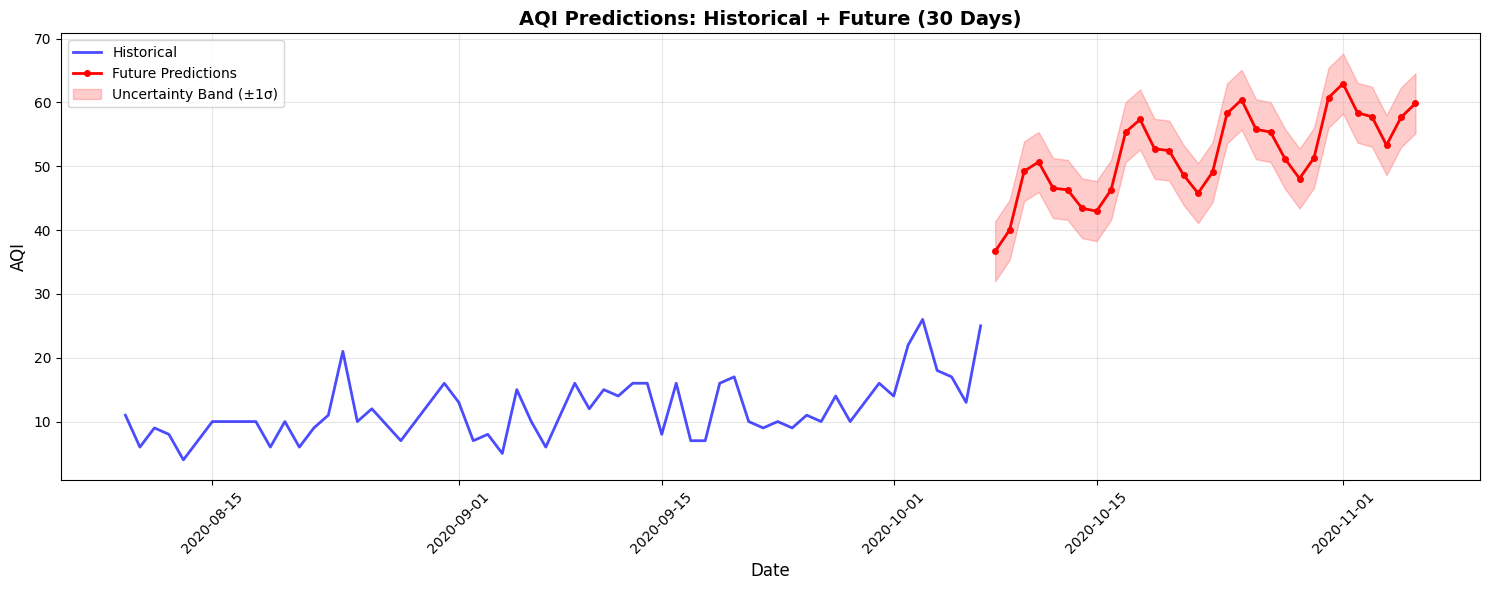


Prediction Statistics:
Mean predicted AQI: 51.81
Min predicted AQI: 36.65
Max predicted AQI: 62.94
Std of predictions: 6.46

Recent historical mean: 13.93
Recent historical std: 4.77


In [12]:
# Visualize future predictions
plt.figure(figsize=(15, 6))

# Plot historical data (last 60 days)
plt.plot(data.index[-60:], data['AQI'].values[-60:], 
         label='Historical', linewidth=2, color='blue', alpha=0.7)

# Plot future predictions
plt.plot(future_dates, future_predictions, 
         label='Future Predictions', linewidth=2, color='red', marker='o', markersize=4)

# Add uncertainty bands (simple approach: ±1 std of recent data)
recent_std = data['AQI'].iloc[-60:].std()
plt.fill_between(future_dates, 
                 future_predictions - recent_std, 
                 future_predictions + recent_std,
                 alpha=0.2, color='red', label='Uncertainty Band (±1σ)')

plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.title('AQI Predictions: Historical + Future (30 Days)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistics about predictions
print("\nPrediction Statistics:")
print(f"Mean predicted AQI: {future_predictions.mean():.2f}")
print(f"Min predicted AQI: {future_predictions.min():.2f}")
print(f"Max predicted AQI: {future_predictions.max():.2f}")
print(f"Std of predictions: {future_predictions.std():.2f}")
print(f"\nRecent historical mean: {data['AQI'].iloc[-30:].mean():.2f}")
print(f"Recent historical std: {data['AQI'].iloc[-30:].std():.2f}")

## Diagnostics: Check for Common Issues

In [13]:
print("Model Diagnostics:")
print("=" * 60)

# 1. Check for monotonic decay
differences = np.diff(future_predictions)
if all(differences < 0):
    print("⚠️  WARNING: Predictions show monotonic decline!")
    print("   This suggests error accumulation or model collapse.")
elif all(differences > 0):
    print("⚠️  WARNING: Predictions show monotonic increase!")
else:
    print("✓ Predictions show variation (good!)")

# 2. Check if predictions are realistic
historical_range = (data['AQI'].min(), data['AQI'].max())
pred_range = (future_predictions.min(), future_predictions.max())

print(f"\n✓ Historical AQI range: {historical_range[0]:.2f} - {historical_range[1]:.2f}")
print(f"  Predicted AQI range: {pred_range[0]:.2f} - {pred_range[1]:.2f}")

if pred_range[0] < historical_range[0] * 0.5 or pred_range[1] > historical_range[1] * 1.5:
    print("⚠️  WARNING: Predictions outside reasonable range!")
else:
    print("✓ Predictions within reasonable range")

# 3. Check prediction variance
print(f"\n✓ Historical variance: {data['AQI'].var():.2f}")
print(f"  Prediction variance: {future_predictions.var():.2f}")

if future_predictions.var() < data['AQI'].var() * 0.1:
    print("⚠️  WARNING: Predictions have very low variance!")
    print("   Model may be converging to mean.")
else:
    print("✓ Prediction variance looks reasonable")

Model Diagnostics:
✓ Predictions show variation (good!)

✓ Historical AQI range: 4.00 - 387.00
  Predicted AQI range: 36.65 - 62.94
✓ Predictions within reasonable range

✓ Historical variance: 2424.98
  Prediction variance: 41.78
⚠️  WARNING: Predictions have very low variance!
   Model may be converging to mean.


## Key Takeaways

### What Was Fixed:
1. **Inverse transform bug**: Now properly scales predictions back to original range
2. **Multi-step training**: Model learns to predict 7 days at once, reducing error accumulation
3. **Feature engineering**: Added time-based features to help capture patterns
4. **Better architecture**: Added dropout, gradient clipping, learning rate scheduling
5. **Diagnostics**: Added checks to detect common failure modes

### Why Predictions Still Might Not Be Perfect:
- AQI is influenced by many external factors (weather, traffic, industrial activity)
- LSTM can only learn from historical patterns
- Longer forecast horizons naturally have more uncertainty
- Consider: ensemble models, external features (weather), different architectures (Transformer)

### Next Steps to Improve Further:
1. Add weather data as features
2. Try ensemble of multiple models
3. Experiment with Transformer architecture
4. Use probabilistic forecasting (predict distributions, not just point estimates)
5. Collect more diverse training data